In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
%matplotlib inline

In [2]:
data = np.loadtxt('applesOranges.csv', skiprows=1, dtype=bytes, delimiter=',').astype(float)

In [20]:
def weight(alpha):
    # Use unit circle definition
    rad = np.radians(alpha)
    return np.array((np.cos(rad), np.sin(rad)))

def f(x, w, theta):
    return (np.sign(w.dot(x) + theta) + 1) / 2

def error(yT, x, w, theta):
    # Use linear error measure and round to decide for a label (0 or 1)
    return np.abs(yT - f(x, w, theta))

def plot(ax, data, **kwargs):
    mapping = np.array(data).T
    ax.plot(mapping[0], mapping[1], **kwargs)
    ax.set_title(kwargs['label'])

def scatter(ax, data, **kwargs):
    mapping = np.array(data).T
    ax.scatter(mapping[0], mapping[1], **kwargs)
    ax.set_title(kwargs['label'])

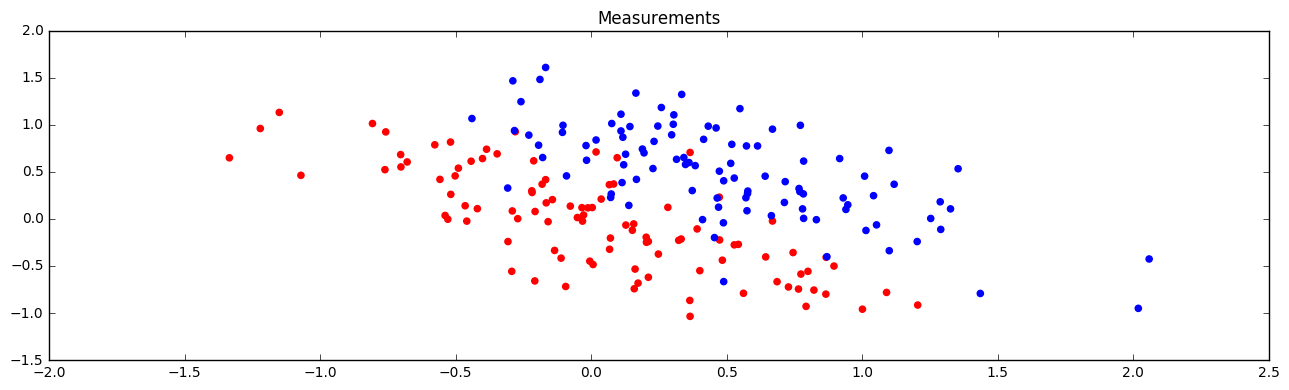

In [9]:
# Exercise 1.a
fig, ax = plt.subplots(1, 1, figsize=(13, 4))
colors = ['red' if x[2]==0 else 'blue' for x in data]
scatter(ax, data[:, :2], label='Measurements', color=colors)
fig.tight_layout()

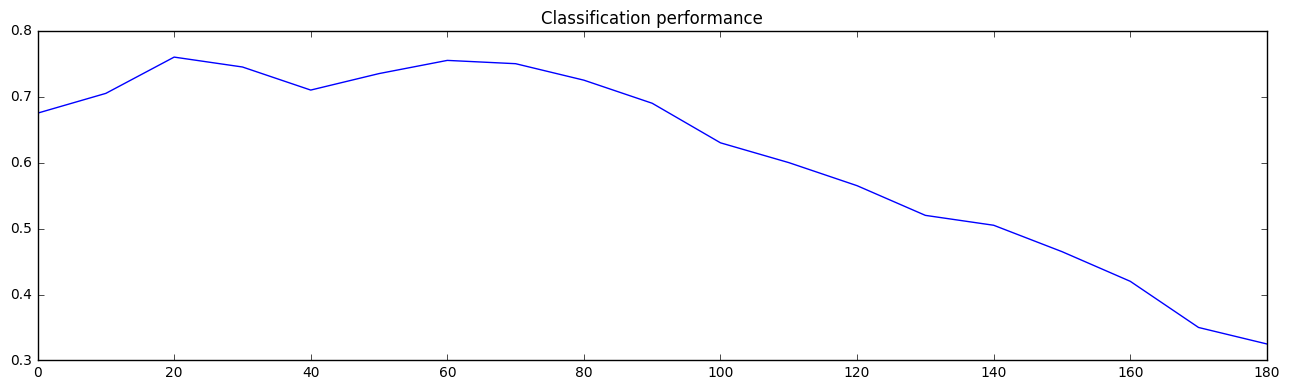

In [21]:
# Exercise 1.b
theta = 0
alphas = range(0, 181, 10)
performances = []

for alpha in alphas:
    w = weight(alpha)
    errors = [error(yT, (x1, x2), w, theta) for x1, x2, yT in data]
    performance = np.average([1 - round(e) for e in errors])
    performances.append((alpha, performance))

fig, ax = plt.subplots(1, 1, figsize=(13, 4))
plot(ax, performances, label='Classification performance')
fig.tight_layout()

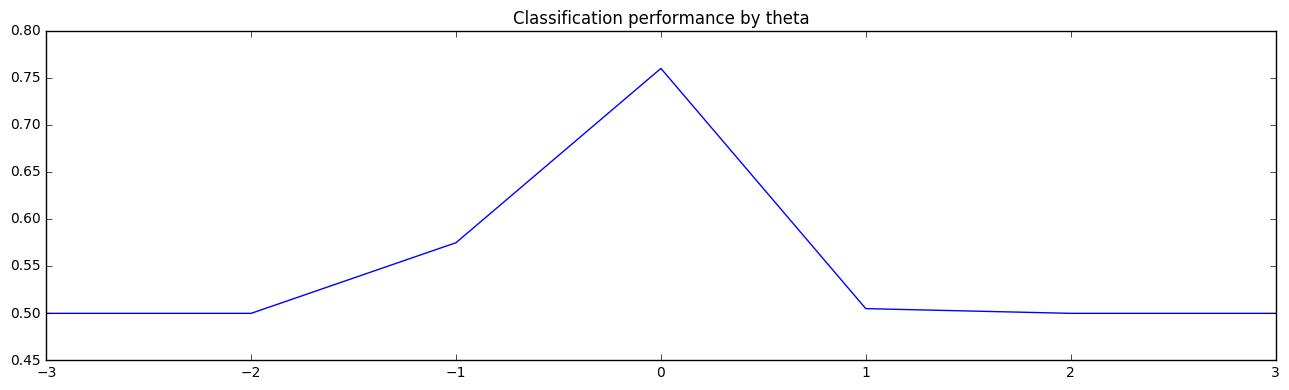

In [26]:
# Exercise 1.c
thetas = range(-3, 4)
alpha = max(performances, key = lambda x: x[1])[0]
w = weight(alpha)
performances2 = []

for theta in thetas:
    errors = [error(yT, (x1, x2), w, theta) for x1, x2, yT in data]
    performance = np.average([1 - round(e) for e in errors])
    performances2.append((theta, performance))
    
fig, ax = plt.subplots(1, 1, figsize=(13, 4))
plot(ax, performances2, label='Classification performance by theta')
fig.tight_layout()

Parameters: Alpha = 20, Theta = 0, Error rate = 0.24


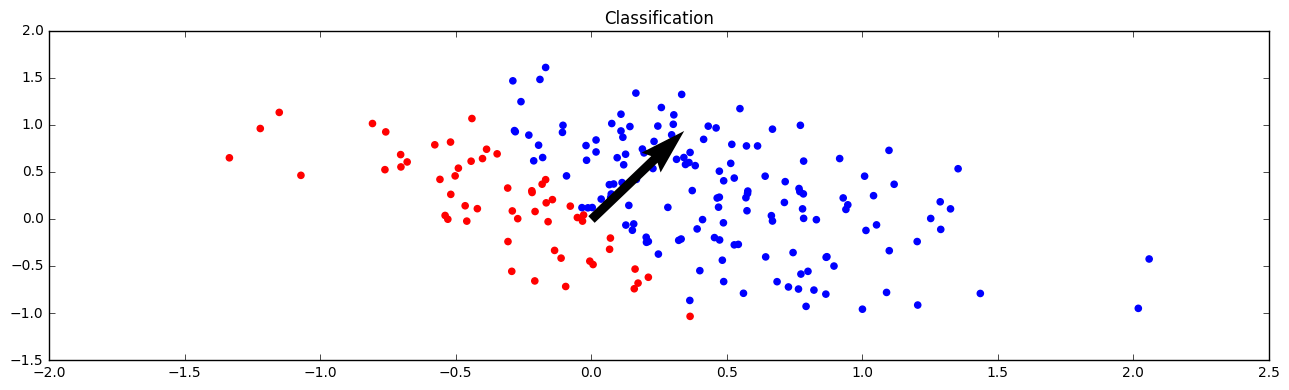

In [38]:
# Exercise 1.d
theta = max(performances2, key = lambda x: x[1])[0]
alpha = max(performances, key = lambda x: x[1])[0]
w = weight(alpha)

fig, ax = plt.subplots(1, 1, figsize=(13, 4))
classification = [f(x[:2], w, theta) for x in data]
eT = np.average([error(yT, (x1, x2), w, theta) for x1, x2, yT in data])
colors = ['red' if x==0 else 'blue' for x in classification]
scatter(ax, data[:, :2], label='Classification', color=colors)
ax.quiver(0, 0, w[1], w[0], angles='xy', scale_units='xy', scale=1)
fig.tight_layout()

print('Parameters: Alpha = {}, Theta = {}, Error rate = {}'.format(alpha, theta, eT))

Interpretation
---

The weighting vector defines if a datapoint is on the left or the right side of it. In the end the scalar product of the weighting vector on a data point returns a positive or a negative number. By applying the sign function to the return value you get one of two possible values defining the label of the given datapoint.

The optimized parameters alpha and theta define the weight vector such that the resulting seperating line is close to the optimal solution. Because there is only one applied connectionist neuron there is only a linear seperating line which doesn't fit exactly to the given measurements.

Best parameters: Alpha = 45, Theta = -0.40, Error rate = 0.09


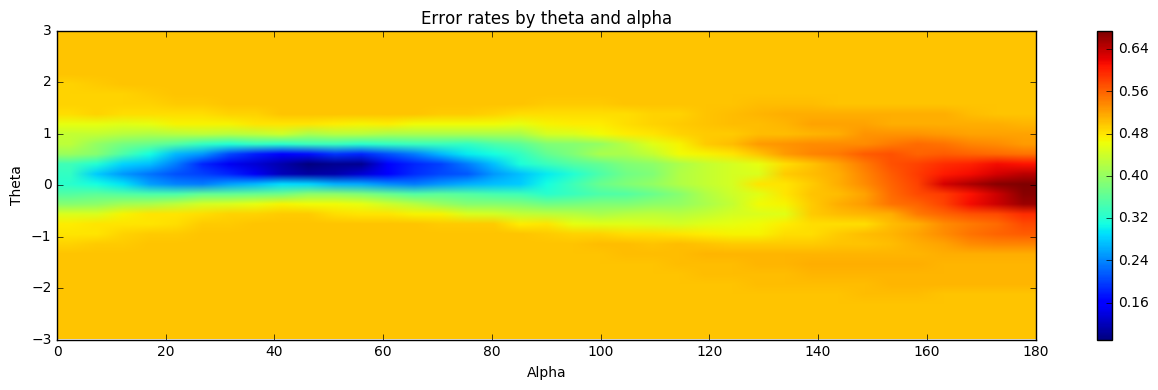

In [17]:
# Exercise 1.e
thetas = np.arange(-3, 3.1, 0.2)
alphas = range(0, 181, 5)
results = []
min_value = 1
best_params = None

for alpha in alphas:
    w = weight(alpha)
    row = []
    for theta in thetas:
        e = [error(yT, (x1, x2), w, theta) for x1, x2, yT in data]
        eT = np.average(e)
        row.append(eT)
        if eT < min_value:
            best_params = (alpha, theta)
            min_value = eT
    results.append(row)


fig, ax = plt.subplots(1, 1, figsize= (13, 4))
cax = ax.imshow(np.array(results).T, extent=[0, 180, -3, 3], aspect='auto')
fig.colorbar(cax)
ax.set_title('Error rates by theta and alpha')
ax.set_ylabel('Theta')
ax.set_xlabel('Alpha')
fig.tight_layout()

print('Best parameters: Alpha = {}, Theta = {:.2f}, Error rate = {}'.format(*best_params, min_value))

Exercise 1.f
==============
> Can the optimization method (e) be applied to any classification problem? Discuss potential problems and give an application example in which the above method must fail.

#FIXME: Problems with many parameters. Low calculation costs using MLP.

Since we're only using a single conntectionist neuron, we are only able to execute a linear classification. The seperating line only is a linear function so we cannot find the right classification for some points which are surrounded by a cloud of points with a different label. If we have a dataset which can be classified by a nonlinear function like a quadratic function we would get even worse results than for the given example, because we cannot reproduce the seperating line with a linear classification.

Exercise 2.a
==============
> Describe a simple example in which a multilayer perceptron (MLP) can distinguish between
two classes, but a single connectionist neuron can not.

| input 1 | input 2 | sum | output |
|:-:|:-:|:-:|:-:|
| 0 | 1 | 1 | 1 |
| 1 | 0 | 1 | 1 |
| 1 | 1 | 2 | 0 |

The output values in this example describe a XOR function.
There is no definition for the set of weights, theta and the transfer function that can map to the output of this example.

Example of a MLP which mocks the XOR function:

* 2 input units, 1 hidden unit (A), 1 output unit (B)
* f(x)=(sgn(x) + 1)/2
* Theta_A = 1.5
* Theta_B = 0.5
* w_A = (1, 1)
* w_B = (1, -2, 1)

#FIXME: example in a coordinate system in which there is no single hyperplane seperating the labeled data.

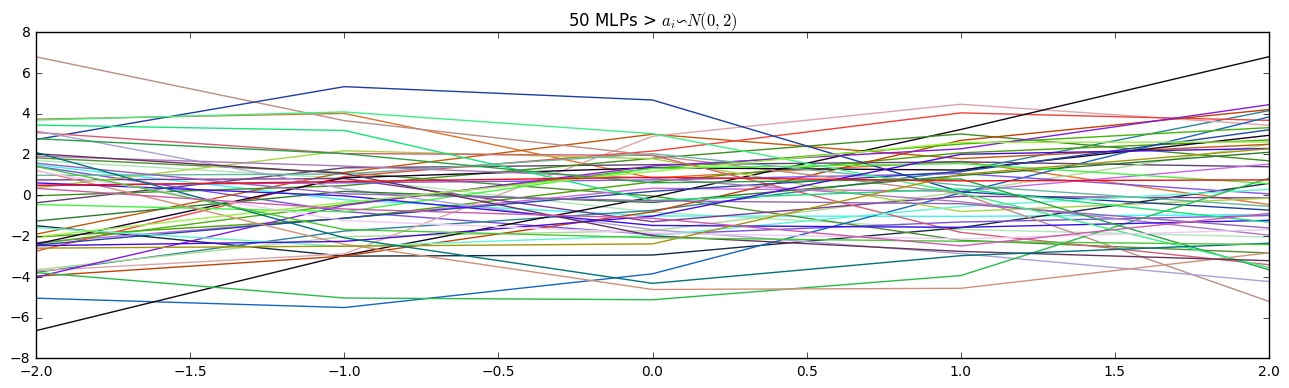

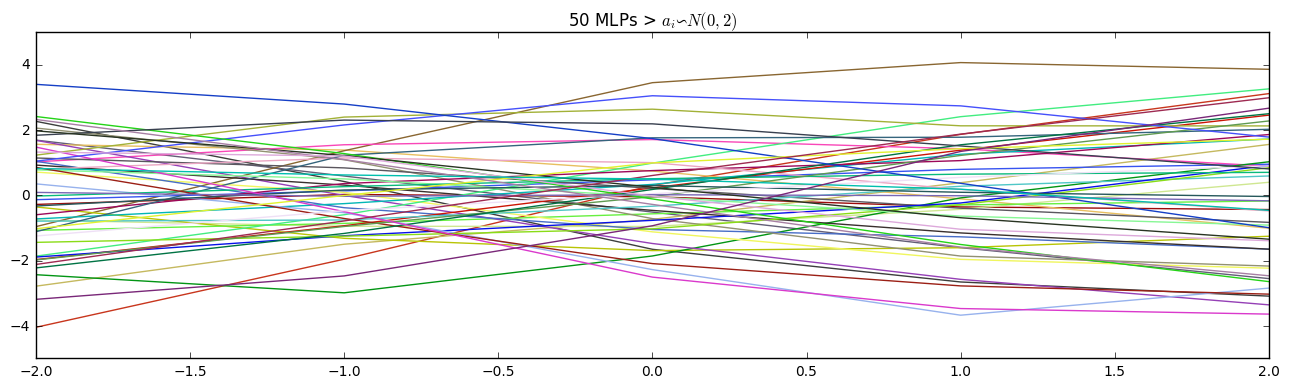

In [66]:
# Exercise 2.b
def y(x, w, f, a, b):
    return (w * f(a * (x - b))).sum()

def generate_mlps(a_variance, f=np.tanh, count=50, nodes=10, xs=np.arange(-2, 3, 1)):
    mlps = [(np.random.normal(loc=0, scale=1, size=nodes),
             np.random.normal(loc=0, scale=a_variance, size=nodes),
             np.random.uniform(-2, 2, nodes))
            for _ in range(count)]
    all_ys = [([y(x, w, f, a, b) for x in xs], w, a, b) for w, a, b in mlps]
    return [(list(zip(xs, ys)), w, a, b) for ys, w, a, b in all_ys]

def plot_mlps(values, **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(13, 4))
    for xs_ys, _, _, _ in values:
        color = np.random.rand(3, 1)
        plot(ax, xs_ys, color=color, **kwargs)
    fig.tight_layout()

functions = generate_mlps(2, np.tanh, 50)
plot_mlps(functions, label=r'50 MLPs > $a_i \backsim N(0, 2)$')

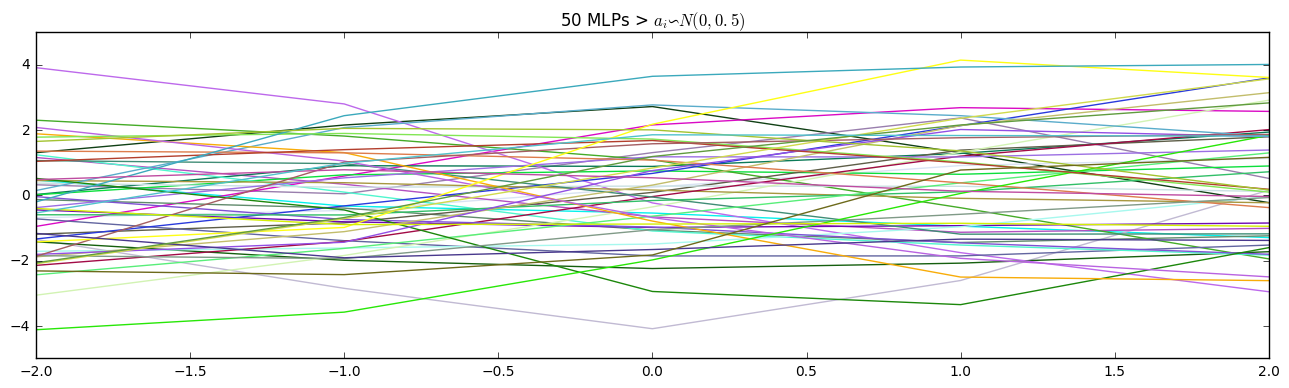

In [63]:
# Exercise 2.c
functions2 = generate_mlps(0.5, np.tanh, 50)
plot_mlps(functions2, label=r'50 MLPs > $a_i \backsim N(0, 0.5)$')

Comparison of 2.b and 2.c
===
In the first plot the functions are more strongly changing as in the second one. The variance of the plotted values increases with a greater normally distributed range of $a_i$. In contrast the functions in the second plot are changing more consistently.


Because of a more likely small $a_i$ the hyperbolic tangent gets streched and results in a smoother switching between positive and negative values. That's why the functions in 2.c are looking more like a linear function for the given values of $x$.

MLP y_1(x):
	MSE=0.07
	w=[-0.77, 0.162, 2.078, 1.146, -0.66, 0.147, -0.37, -0.45, -0.31, 0.4]
	a=[0.039, -0.19, -0.55, 0.421, 0.683, 0.187, 1.132, 0.342, 1.173, 0.279]
	b=[1.879, -0.94, 0.074, -0.52, -1.34, -0.93, -1.6, 1.732, 0.178, 0.395]

MLP y_2(x):
	MSE=0.21
	w=[-0.74, -0.58, 1.003, -0.73, -1.43, 0.166, 0.705, -0.52, 1.176, -1.09]
	a=[0.158, -1.0, 0.207, 0.462, 0.334, 0.275, -0.35, -0.45, -0.95, 0.522]
	b=[-0.08, -0.13, 1.228, -1.07, -1.01, 1.286, -1.71, -1.15, 0.644, 1.206]



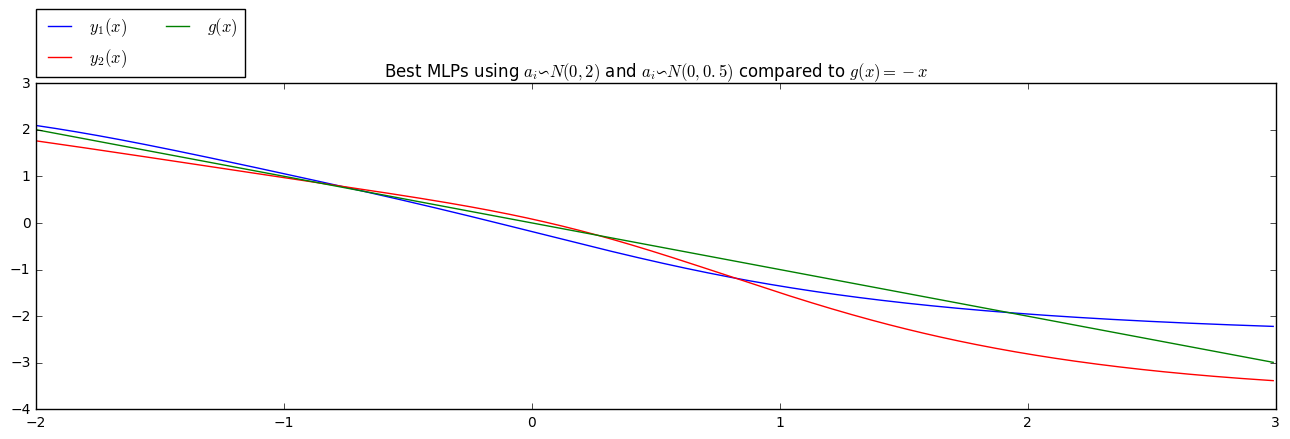

In [67]:
# Exercise 2.d

# Input values for evaluation
xs = np.arange(-2, 3, 0.01)
g = lambda x: -x
all_gs = [(x, g(x)) for x in xs]
all_ys1 = generate_mlps(2, xs=xs)
squared_errors1 = [(np.average([(xy[1] - xg[1])**2 for xg, xy in zip(all_gs, all_ys)]), all_ys, w, a, b)
                  for all_ys, w, a, b in all_ys1]
all_ys2 = generate_mlps(0.5, xs=xs)
squared_errors2 = [(np.average([(xy[1] - xg[1])**2 for xg, xy in zip(all_gs, all_ys)]), all_ys, w, a, b)
                  for all_ys, w, a, b in all_ys2]

best_mlp1 = min(squared_errors1, key=lambda x: x[0])
best_mlp2 = min(squared_errors2, key=lambda x: x[0])

fig, ax = plt.subplots(1, 1, figsize=(13, 4))
plot(ax, best_mlp1[1], label=r'$y_1(x)$', color='blue')
plot(ax, best_mlp2[1], label=r'$y_2(x)$', color='red')
plot(ax, all_gs, label=r'$g(x)$', color='green')
ax.set_title(r'Best MLPs using $a_i \backsim N(0, 2)$ and $a_i \backsim N(0, 0.5)$ compared to $g(x) = -x$')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, borderaxespad=0.)
fig.tight_layout()

w, a, b = [[float(str(x)[:5]) for x in param] for param in best_mlp1[2:]]
print('MLP y_1(x):\n\tMSE={:.2f}\n\tw={}\n\ta={}\n\tb={}\n'.format(best_mlp1[0], w, a, b))
w, a, b = [[float(str(x)[:5]) for x in param] for param in best_mlp2[2:]]
print('MLP y_2(x):\n\tMSE={:.2f}\n\tw={}\n\ta={}\n\tb={}\n'.format(best_mlp2[0], w, a, b))